# Networks of organisations


  
* *Exploratory SNA* book's chapter 5 about 'Affiliations'
* Cf. [this notebook](https://github.com/Sciences-historiques-numeriques/histoire_numerique_methodes/blob/main/analyse_reseaux/pajek_book/chapter5_affiliations.ipynb) 



In [1]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet

%matplotlib inline

from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd

import scipy.stats as stats

import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import seaborn as sns
import math
import os

In [2]:
### Librairies déjà installées avec Python
import pprint
import csv

import sqlite3 as sql

import time
import datetime
from dateutil import parser


from shutil import copyfile


In [3]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

import sys
from importlib import reload

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf
import network_analysis_functions as naf

In [4]:
print(reload(naf))  

<module 'network_analysis_functions' from '/home/Aplication numerique /network_analysis_functions.py'>


## Get the data from the triplestore

This notebook is based on the same relationships (and therefore data) as [the one about persons' relationships](wdt_persons_organisations_networks.ipynb), namely the relationship between persons and organisations as original information.

Here, however, we will focus on relationships between institutions, so the treatment is different.


In [5]:
## define SPARQL enpoint
endpoint = "https://ag16vva57r0v2dln.allegrograph.cloud/repositories/nobel-laureats"

In [6]:
query = """

PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>


SELECT ?person (MIN(?pLabel) AS ?personLabel)
        (MIN(?birthYear) AS ?birthYear)
        ?relationship 
        ?organisation (MIN(?oLabel) AS ?organisationLabel)
        (COUNT(*) as ?n) 
        (GROUP_CONCAT(DISTINCT ?groupTypeLabel; separator=" | ") AS ?groupTypes) 
        #(GROUP_CONCAT(DISTINCT ?countryLabel; separator=" | ") AS ?countries) 

WHERE {
        GRAPH <https://github.com/VericaD/nobel_laureates_pc/blob/main/graph/wikidata-imported-data.md>
        {
        {?person a wd:Q5;
           rdfs:label ?pLabel;
           wdt:P569 ?birthYear.
        }


        {?person wdt:P108 ?organisation.
        BIND('employment' AS ?relationship)
        }   
        UNION
        {?person wdt:P463 ?organisation.
        BIND('membership' AS ?relationship)
        }   
        UNION
        {?person wdt:P69 ?organisation.
        BIND('education' AS ?relationship)
        }  
        ?organisation rdfs:label ?oLabel;
                # instance of
                wdt:P31 ?groupType.
        ?groupType rdfs:label ?groupTypeLabel         
        
        # OPTIONAL {
        #    ?organisation wdt:P17 ?country.
        #    ?country rdfs:label ?countryLabel.
        # }

         }        



    }

GROUP BY ?person ?relationship ?organisation   
ORDER by ?person 
"""

In [7]:
### Executer la requête avec les fonctions de la librairie locale
try:
    qr = spqf.get_json_sparql_result(endpoint,query)
    out = [l for l in spqf.sparql_result_to_list(qr)]
    print(len(out))
    pprint.pprint(out[100:103])
except Exception as e:
    print(e)    


7732
[['http://www.wikidata.org/entity/Q102419',
  'Derek Barton',
  '1918',
  'employment',
  'http://www.wikidata.org/entity/Q375606',
  'Birkbeck, University of London',
  '4',
  'public research university | constituent college | higher education '
  'institution | educational organization'],
 ['http://www.wikidata.org/entity/Q102419',
  'Derek Barton',
  '1918',
  'employment',
  'http://www.wikidata.org/entity/Q189022',
  'Imperial College London',
  '4',
  'public research university | educational organization | building | '
  'university'],
 ['http://www.wikidata.org/entity/Q102419',
  'Derek Barton',
  '1918',
  'education',
  'http://www.wikidata.org/entity/Q5597915',
  'Gravesend Grammar School',
  '4',
  "academy school | boys' school | grammar school | secondary school"]]


## Inspect the data


In [8]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(out)
df_p.columns = ['uriPer', 'labelPer', 'birthYear', 'relaType', 'uriOrg', 'labelOrg', 'nTypes',
                'typesOrg']
print('Number: ',len(df_p))
df_p.iloc[10:13,:]


Number:  7732


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg
10,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,membership,http://www.wikidata.org/entity/Q123885,Royal Society,6,national academy | publishing company | open-a...
11,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,education,http://www.wikidata.org/entity/Q35794,University of Cambridge,4,educational organization | public research uni...
12,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,employment,http://www.wikidata.org/entity/Q21578,Princeton University,5,research university | private university | Col...


### Distribution of relationships in relation to birthYears of organisations members

In [9]:
l_50 = list(range(1761, 2051, 30))
print(l_50)

[1761, 1791, 1821, 1851, 1881, 1911, 1941, 1971, 2001, 2031]


In [10]:
### We adapt the periods manually,
# we would like to have eight periods
# making sense from an historical point of view 
lc = [1751, 1801, 1851, 1901, 1921, 1941, 1961, 1981, 2001]

In [11]:
### 30 years periods, but some customisations
lc = [1751, 1811, 1851, 1881, 1911, 1941, 1971, 2001]

In [12]:
### convert birthYear to integer
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [13]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année
df_p['periods'] = pd.cut(df_p['birthYear'], lc, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['periods'] = df_p['periods'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.iloc[[1,5,10]]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods
1,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,membership,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,3,academic publisher | learned society | nonprof...,1941-1970
5,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,employment,http://www.wikidata.org/entity/Q217365,Bell Labs,3,research institute | publishing company | priv...,1941-1970
10,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,membership,http://www.wikidata.org/entity/Q123885,Royal Society,6,national academy | publishing company | open-a...,1941-1970


#### Reload from CSV

This is only possible if you already stored the data into a CSV, cf. below

In [14]:
### load from CSV

file_add = 'persons_organisations_from_organisations.csv'
df_p=pd.read_csv(file_add)
print(len(df_p))
df_p.head(2)

7732


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
0,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,employment,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,1,organization,1941-1970,['organization']
1,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,membership,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,3,academic publisher | learned society | nonprof...,1941-1970,"['academic publisher', 'learned society', 'non..."


In [15]:
### Group by periods
df_period = df_p.groupby(by='periods', observed=True).size()
print(df_period)

periods
1811-1850     251
1851-1880    1053
1881-1910    1985
1911-1940    2939
1941-1970    1479
1971-2000      25
dtype: int64


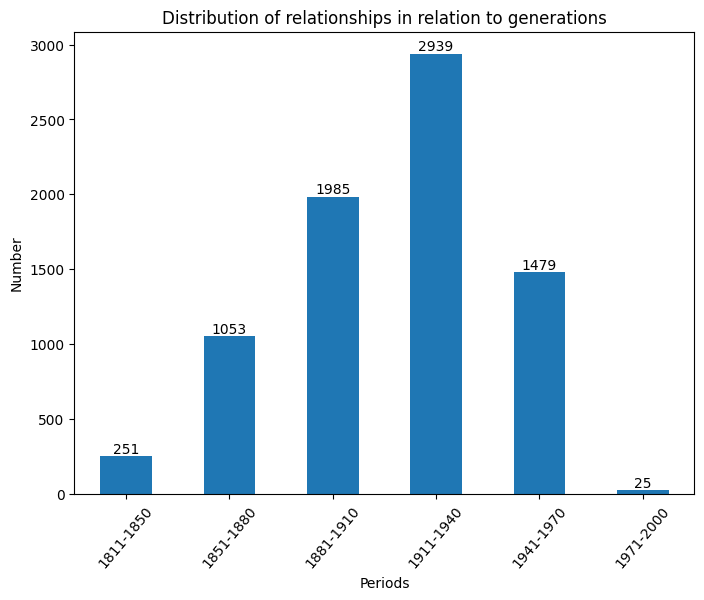

In [16]:
ax = df_period.plot(kind='bar',rot=50, fontsize=10, figsize=(8,6))
ax.bar_label(ax.containers[-1], size=10)
plt.ylabel('Number')
plt.xlabel('Periods')
plt.title('Distribution of relationships in relation to generations')
plt.show()

### Inspect available relationships

In [17]:
### Available relationships
print(df_p.groupby(by='relaType').size())

relaType
education     1996
employment    1876
membership    3860
dtype: int64


In [18]:
dfg_pr=df_p.groupby(by=['periods','relaType'], observed=True, as_index=False).size()
print(dfg_pr)

      periods    relaType  size
0   1811-1850   education    50
1   1811-1850  employment    46
2   1811-1850  membership   155
3   1851-1880   education   238
4   1851-1880  employment   231
5   1851-1880  membership   584
6   1881-1910   education   471
7   1881-1910  employment   488
8   1881-1910  membership  1026
9   1911-1940   education   794
10  1911-1940  employment   693
11  1911-1940  membership  1452
12  1941-1970   education   433
13  1941-1970  employment   411
14  1941-1970  membership   635
15  1971-2000   education    10
16  1971-2000  employment     7
17  1971-2000  membership     8


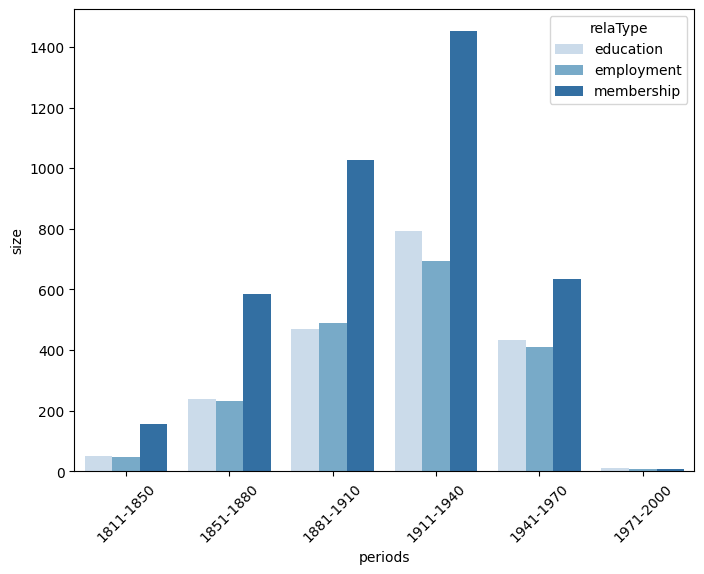

In [19]:
%matplotlib inline
plt.figure(figsize=(8, 6)) 
ax = sns.barplot(data=dfg_pr, x='periods', y='size', hue='relaType', palette='Blues')
ax.tick_params(axis='x', labelrotation=45)


### Clean up organisations type

In [20]:
### Transform types' strings to alphabetically sorted lists and delete additional white spaces
df_p['listTypesOrg'] = df_p.typesOrg.apply(lambda x : sorted([e.strip().lower() for e in x.split('|')]))

ll = df_p.listTypesOrg.to_list()
print(len(ll))
pprint.pprint(ll[:3])


7732
[['organization'],
 ['academic publisher', 'learned society', 'nonprofit organization'],
 ['college of the university of cambridge']]


In [21]:
## Rebuild the sorted original texts after sorting
df_p['typesOrg'] = df_p.listTypesOrg.apply(lambda x : ' | '.join(x))
df_p.iloc[[1,5,10]]


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
1,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,membership,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,3,academic publisher | learned society | nonprof...,1941-1970,"[academic publisher, learned society, nonprofi..."
5,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,employment,http://www.wikidata.org/entity/Q217365,Bell Labs,3,privately held company | publishing company | ...,1941-1970,"[privately held company, publishing company, r..."
10,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,membership,http://www.wikidata.org/entity/Q123885,Royal Society,6,academy of sciences | learned society | nation...,1941-1970,"[academy of sciences, learned society, nationa..."


#### Organisations' types distribution

In [22]:
print(df_p.groupby('typesOrg').size().sort_values(ascending=False).iloc[:10])

typesOrg
academic publisher | academy of sciences | production company | publishing company                                      483
academic publisher | learned society | nonprofit organization                                                           462
academy of sciences                                                                                                     325
academy of sciences | learned society | national academy | open-access publisher | organization | publishing company    311
academy of sciences | learned society | national academy                                                                187
academy of sciences | publishing company                                                                                135
academy of sciences | archive | national academy                                                                        132
colonial colleges | private not-for-profit educational institution | private university | research university           127

#### Save dataframe to CSV

In [23]:
file_add = 'persons_organisations_from_organisations.csv'
df_p.to_csv(file_add, index=False, sep=',', quotechar='"')

## Types of organisations

Property **wdt:P31 instance of**


We are trying to figure out if we can use these types to distinguish and categorise organisations. We will introduce high-level, research-driven classes that primarily serve a heuristic function and express no objective point of view.

In [24]:
### Inspect the available composed types
df_types = pd.DataFrame(df_p.groupby('typesOrg').size().sort_values(ascending=False))
df_types.reset_index(inplace=True)
df_types.columns=['typesOrg', 'number']
df_types['numberOrg'] = df_types.typesOrg.apply( lambda x: len(x.split('|')))
df_types.iloc[:10]

,typesOrg,number,numberOrg
0,academic publisher | academy of sciences | pro...,483,4
1,academic publisher | learned society | nonprof...,462,3
2,academy of sciences,325,1
3,academy of sciences | learned society | nation...,311,6
4,academy of sciences | learned society | nation...,187,3
5,academy of sciences | publishing company,135,2
6,academy of sciences | archive | national academy,132,3
7,colonial colleges | private not-for-profit edu...,127,4
8,learned society | open-access publisher | publ...,114,4
9,high school,113,1


In [25]:
### Print to CSV in order to inspect the data
csv_file='files/network_organisations_types_groups.csv'
df_types.to_csv(csv_file)

### Add organisation main type

In [26]:
### Inspect the data
df_p.head(1)

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
0,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,employment,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,1,organization,1941-1970,[organization]


In [27]:
def code_organisation_main_type(x):
    val = ''
    if 'institute of technol' in x:
        val = 'institute of technology'
    elif 'polyt' in x:
        val = 'institute of technology'    
    elif 'observato' in x:
        val = 'astronomical observatory'  
    elif 'public university' in x:
        val = 'public university'
    elif 'école normale sup' in x:
        val = 'public university'    
    elif 'grande école' in x:
        val = 'public university'
    elif 'grand établissement' in x:
        val = 'public university'
    elif 'private university' in x:
        val = 'private university'
    elif 'university' in x:
        val = 'university'   
    elif 'educational inst' in x:
        val = 'educational institution'    
    elif 'military academy' in x:
        val = 'educational institution' 
    elif 'naval academy' in x:
        val = 'educational institution'        
    elif 'art academy' in x:
        val = 'educational institution' 
    elif 'faculty' in x:
        val = 'university'  # could also be 'faculty'
    elif 'academic dep' in x:
        val =  'university'  # could also be 'faculty'    
    elif 'college' in x:
        val = 'educational institution'   # could also be 'college'             
    elif 'gymnas' in x:
        val = 'educational institution'   # could also be 'college'
    elif 'learned society' in x:
        val = 'learned society'     
    elif 'academy of sciences' in x:
        val = 'academy of sciences'
    elif 'research institute' in x:
        val = 'research organisation'
    elif 'max planck' in x:
        val = 'research organisation'
    elif 'institute' in x:
        val = 'research organisation' 
    elif 'research' in x:
        val = 'research organisation'
    elif 'laboratory' in x:
        val = 'research facility'  
    elif 'facility' in x:
        val = 'research facility'   
    elif 'scientific society' in x:
        val = 'scientific organisation'
    elif 'scientific society' in x:
        val = 'scientific organisation'
    elif 'museum' in x:
        val = 'scientific organisation'
    elif 'nonprofit organization' in x:
        val = 'scientific organisation'    
    elif 'national academy' in x:
        val = 'scientific organisation'
    elif 'scientific organization' in x:
        val = 'scientific organisation'
    elif 'higher education' in x:
        val = 'educational institution'
    elif 'school' in x:
        val = 'educational institution'   # could also be 'high school or similar'
    elif 'academic institution' in x:
        val = 'educational institution'   # could also be 'high school or similar'
    elif 'academy' in x:
        val = 'learned society'
    elif 'society' in x:
        val = 'learned society'      
    elif 'company' in x \
                or 'business'  in x \
                or 'entrepr' in x:
        val = 'company or gov. agency' # could also be 'company'
    elif 'government' in x :
        val = 'company or gov. agency' # could also be 'government agency'         
    elif 'publish' in x :
        val = 'company or gov. agency' # could also be 'publisher_edition'     
    elif 'journal' in x :
        val = 'company or gov. agency' # could also be 'publisher_edition'
    elif 'periodical' in x :
        val = 'company or gov. agency' # could also be 'publisher_edition'    
    else:
        val = 'not classified organisation'

    return val        

In [28]:
df_p['orgMainType'] = df_p['typesOrg'].apply(lambda x : code_organisation_main_type(x))
df_p.iloc[7:10]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg,orgMainType
7,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,employment,http://www.wikidata.org/entity/Q622664,"University of California, San Diego",2,public educational institution of the united s...,1941-1970,[public educational institution of the united ...,public university
8,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,employment,http://www.wikidata.org/entity/Q156598,Leiden University,2,organization | university,1941-1970,"[organization, university]",university
9,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,employment,http://www.wikidata.org/entity/Q4614,University of Southern California,4,open-access publisher | private not-for-profit...,1941-1970,"[open-access publisher, private not-for-profit...",private university


In [29]:
df_mainTypes = pd.DataFrame(df_p.groupby(by='orgMainType', as_index=False).size().sort_values(by='size',ascending=False))
df_mainTypes.columns=['mainType', 'number']
df_mainTypes

,mainType,number
0,academy of sciences,1845
12,university,1554
5,learned society,1438
3,educational institution,654
8,public university,654
7,private university,502
11,scientific organisation,361
6,not classified organisation,219
10,research organisation,194
4,institute of technology,157


In [30]:
### Inspect the available composed types
df_types = pd.DataFrame(df_p.groupby(['typesOrg', 'orgMainType'], as_index=False).\
                        size().sort_values(by='size',ascending=False))
df_types.columns=['typesOrg', 'orgMainType', 'number']
df_types['numberOrg'] = df_types.typesOrg.apply( lambda x: len(x.split('|')))
### Print to CSV in order to inspect the data
csv_file='files/network_organisations_with_main_types_groups.csv'
df_types.to_csv(csv_file)

df_types.iloc[7:10]

,typesOrg,orgMainType,number,numberOrg
278,colonial colleges | private not-for-profit edu...,private university,127,4
548,learned society | open-access publisher | publ...,learned society,114,4
435,high school,educational institution,113,1


#### 'Manual' corrections and classification improvements

In some cases, instpecting the organisations shows that the provided classification is not suitable and should be replaced:

Academia Europaea, ...

We provide this example merely to illustrate the point; further work would be required, but this is beyond the scope of this exercise.

In [31]:
### Please note the warning and the orders fo the filter, after (!) the column 
"""
Do not use:
df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
"""

df_p.loc[df_p.uriOrg == 'http://www.wikidata.org/entity/Q337234', 'orgMainType'] = 'research organisation'
df_p[df_p.labelOrg.str.contains('Europaea')].head(2)



,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg,orgMainType
165,http://www.wikidata.org/entity/Q103598,Luc Montagnier,1932,membership,http://www.wikidata.org/entity/Q337234,Academia Europaea,3,academy | charitable organization | organization,1911-1940,"[academy, charitable organization, organization]",research organisation
264,http://www.wikidata.org/entity/Q104607,Andrew Huxley,1917,membership,http://www.wikidata.org/entity/Q337234,Academia Europaea,3,academy | charitable organization | organization,1911-1940,"[academy, charitable organization, organization]",research organisation


# Create graphs

In [32]:
### Available relationships
print(df_p.groupby(by='relaType').size())

relaType
education     1996
employment    1876
membership    3860
dtype: int64


### Prepare the dataframe

In [33]:
### Select the columns that will be used
df_prep = df_p[['uriPer','labelPer','birthYear','uriOrg', 'labelOrg', 'typesOrg', 'orgMainType', 'relaType', 'periods']].copy(deep=True)
print(len(df_prep))

7732


### Features of organisations

#### General grouping


We first group by organisations, counting all relationships of persons which provides the total degree or number of members over the whole time 

In [34]:
### Memberships by organisations
df_org = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'typesOrg','orgMainType'],as_index=False).size())
df_org.columns=['uriOrg', 'labelOrg', 'typesOrg', 'orgMainType','tot_members_number']
df_org.sort_values('tot_members_number',ascending=False).iloc[:10]

,uriOrg,labelOrg,typesOrg,orgMainType,tot_members_number
629,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academic publisher | academy of sciences | pro...,academy of sciences,483
928,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,academic publisher | learned society | nonprof...,learned society,462
174,http://www.wikidata.org/entity/Q123885,Royal Society,academy of sciences | learned society | nation...,learned society,311
1086,http://www.wikidata.org/entity/Q543804,German Academy of Sciences Leopoldina,academy of sciences | learned society | nation...,learned society,187
1482,http://www.wikidata.org/entity/Q83172,Russian Academy of Sciences,academy of sciences | publishing company,academy of sciences,133
936,http://www.wikidata.org/entity/Q466113,American Physical Society,learned society | open-access publisher | publ...,learned society,114
220,http://www.wikidata.org/entity/Q13371,Harvard University,colonial colleges | private not-for-profit edu...,private university,113
935,http://www.wikidata.org/entity/Q466089,American Philosophical Society,learned society | nonprofit organization,learned society,108
463,http://www.wikidata.org/entity/Q191583,Royal Swedish Academy of Sciences,academy of sciences | building | national acad...,academy of sciences,107
452,http://www.wikidata.org/entity/Q188771,French Academy of Sciences,academy of sciences | archive | national academy,academy of sciences,96


In [35]:
### Save list of organisations as CSV
csv_file='files/network_organisations_with_main_type_and_number.csv'
df_org.sort_values('tot_members_number',ascending=False).to_csv(csv_file)

#### Group by period

We then group by heuristic period (or generation)

In [36]:
df_orgPeriod = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType', 'periods']).size(), columns=['period_members_number'])
df_orgPeriod.reset_index(inplace=True)
df_orgPeriod.sort_values(by='periods', ascending=True).head()

,uriOrg,labelOrg,orgMainType,periods,period_members_number
284,http://www.wikidata.org/entity/Q131262,University of Bologna,public university,1811-1850,1
104,http://www.wikidata.org/entity/Q1137665,Ghent University,public university,1811-1850,1
227,http://www.wikidata.org/entity/Q123885,Royal Society,learned society,1811-1850,7
1326,http://www.wikidata.org/entity/Q392066,Zofingia,not classified organisation,1811-1850,1
988,http://www.wikidata.org/entity/Q2657904,French Defence Health service,not classified organisation,1811-1850,1


In [37]:
df_orgPeriod[df_orgPeriod.labelOrg=='AMOLF']

,uriOrg,labelOrg,orgMainType,periods,period_members_number


#### Group by period and relationship type

We then group by heuristic period (or generation) AND relationship type, i.e. which kind of relationship associates a person to an organisation in the bipartite network

In [38]:
df_orgPeriodRelType = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType', 'relaType', 'periods']).size(), columns=['period_members_number'])
df_orgPeriodRelType.reset_index(inplace=True)
df_orgPeriodRelType.sort_values(by='period_members_number', ascending=False).head()

,uriOrg,labelOrg,orgMainType,relaType,periods,period_members_number
1208,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,membership,1911-1940,219
1726,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,membership,1911-1940,214
1725,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,membership,1881-1910,117
1209,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,membership,1941-1970,116
249,http://www.wikidata.org/entity/Q123885,Royal Society,learned society,membership,1911-1940,110


In [39]:
### Number of relationships by period with type
dfgt = df_orgPeriodRelType.groupby(['periods', 'relaType', 'orgMainType'], as_index=False)\
    .sum('members').sort_values(['relaType', 'periods'])
file_addr='files/organisations_types_periods_distribution.csv'
dfgt.sort_values(['relaType', 'periods']).to_csv(file_addr)
print(len(dfgt))
dfgt.iloc[:10]

146


,periods,relaType,orgMainType,period_members_number
0,1811-1850,education,educational institution,9
1,1811-1850,education,institute of technology,1
2,1811-1850,education,not classified organisation,3
3,1811-1850,education,public university,16
4,1811-1850,education,research facility,2
5,1811-1850,education,university,19
21,1851-1880,education,astronomical observatory,1
22,1851-1880,education,educational institution,53
23,1851-1880,education,institute of technology,9
24,1851-1880,education,not classified organisation,9


In [40]:
### Number of relationships without period
dfgw = df_orgPeriodRelType.groupby(['relaType', 'orgMainType'], as_index=False)\
    .sum('members').sort_values([ 'relaType', 'orgMainType'])
print(len(dfgw))

32


## Bivariate analysis: relationship, organisation type

### Create the needed functions

In [121]:
### ct_m : contingency table without totals in margins
def bivariee_stats(ct_wm):
    
    
    n = ct_wm.sum().sum()

    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(ct_wm)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)

    

    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(ct_wm, method='cramer')
    print('Cramer: ', vc)

    return None





In [122]:
### ct_m : contingency tables with totals in margins
def plot_chi2_residuals(ct_wm, figsize=(9,3)):
    
    D = ct_wm

    
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes
   

    fig, ax = plt.subplots(figsize=figsize)         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

    return residus_ponderes

### Explore contingency table : types of relationships, types of organisations

In [123]:


### Contingency table
X = 'relaType'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



relaType,education,employment,membership,Total
orgMainType,,,,
academy of sciences,3,22,1820,1845
astronomical observatory,1,9,0,10
company or gov. agency,0,48,52,100
educational institution,539,68,47,654
institute of technology,77,80,0,157
learned society,2,1,1356,1359
not classified organisation,26,51,142,219
private university,232,270,0,502
public university,321,333,0,654


In [44]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)
ct_wm

relaType,education,employment,membership
orgMainType,,,
academy of sciences,3,22,1820
astronomical observatory,1,9,0
company or gov. agency,0,48,52
educational institution,539,68,47
institute of technology,77,80,0
learned society,2,1,1356
not classified organisation,26,51,142
private university,232,270,0
public university,321,333,0


In [45]:
### We observe a strong relationship between these two variables

bivariee_stats(ct_wm)

Chi2 : 7776.05 , dof : 24
p-value : 0.0
phi2 = inertie (variance totale) : 1.005697408715046
Cramer:  0.7091182583726942


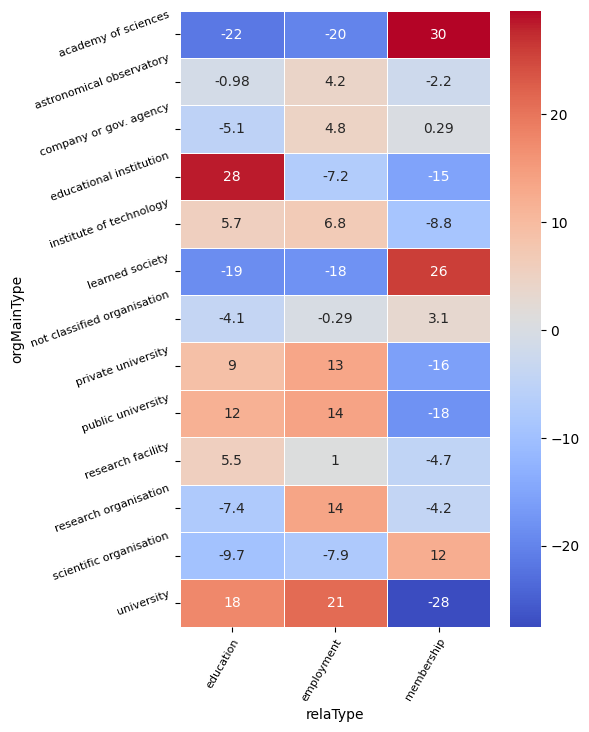

In [46]:
pp = plot_chi2_residuals(ct_wm, figsize=(5, 8))

#### Comment

We observe a strong relationship between these two variables which is explained by the fact that not all organisations types are concerned by the same relationship types

We also observe that some values should be corrected, like memberships in technical organisations that should be employments.

See the following example

In [47]:
pprint.pprint(list(df_p.loc[df_p.orgMainType.str.contains('techno') & df_p.relaType.str.contains('memb') ].items())[:6])

[('uriPer', Series([], Name: uriPer, dtype: object)),
 ('labelPer', Series([], Name: labelPer, dtype: object)),
 ('birthYear', Series([], Name: birthYear, dtype: int64)),
 ('relaType', Series([], Name: relaType, dtype: object)),
 ('uriOrg', Series([], Name: uriOrg, dtype: object)),
 ('labelOrg', Series([], Name: labelOrg, dtype: object))]


### Explore contingency table of relationships to organisations : periods, types of organisations

In [48]:
### Contingency table
X = 'periods'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1811-1850,1851-1880,1881-1910,1911-1940,1941-1970,1971-2000,Total
orgMainType,,,,,,,
academy of sciences,93,362,491,619,278,2,1845
astronomical observatory,0,1,2,3,4,0,10
company or gov. agency,0,10,28,43,17,2,100
educational institution,14,66,153,267,151,3,654
institute of technology,2,14,42,55,43,1,157
learned society,29,145,392,560,230,3,1359
not classified organisation,20,38,54,77,29,1,219
private university,1,21,107,264,107,2,502
public university,33,112,217,181,111,0,654


In [49]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [50]:
### We observe some not so strong relationship between these two variables
bivariee_stats(ct_wm)

Chi2 : 433.9 , dof : 60
p-value : 4.464939439748195e-58
phi2 = inertie (variance totale) : 0.0561173330376587
Cramer:  0.10594086372845815


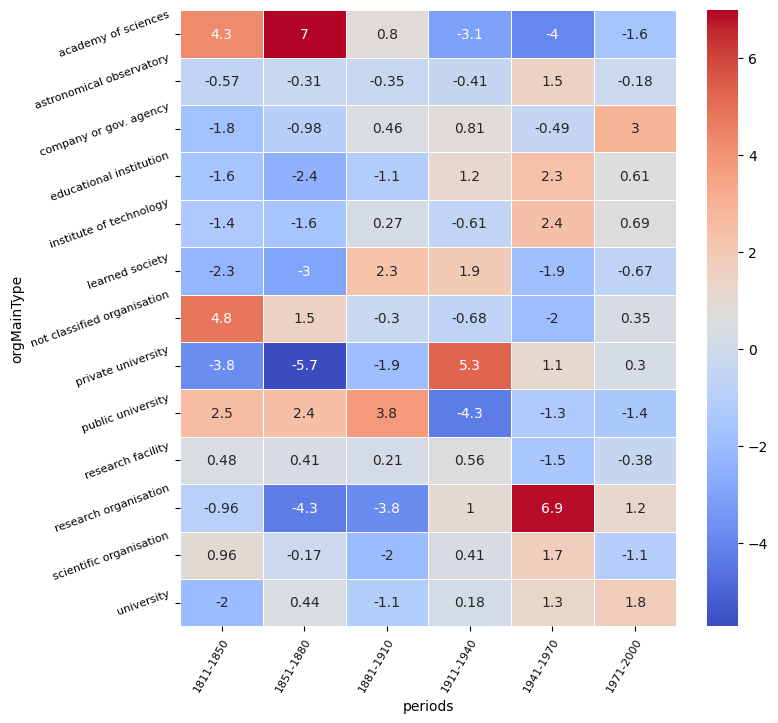

In [51]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 8))

### Explore contingency table of relationships to organisations : periods, types of relationships

In [52]:
### Contingency table
X = 'periods'
Y = 'relaType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1811-1850,1851-1880,1881-1910,1911-1940,1941-1970,1971-2000,Total
relaType,,,,,,,
education,50,238,471,794,433,10,1996
employment,46,231,488,693,411,7,1876
membership,155,584,1026,1452,635,8,3860
Total,251,1053,1985,2939,1479,25,7732


In [53]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [54]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 66.74 , dof : 10
p-value : 1.881518338264125e-10
phi2 = inertie (variance totale) : 0.008631579611265398
Cramer:  0.0656946710596278


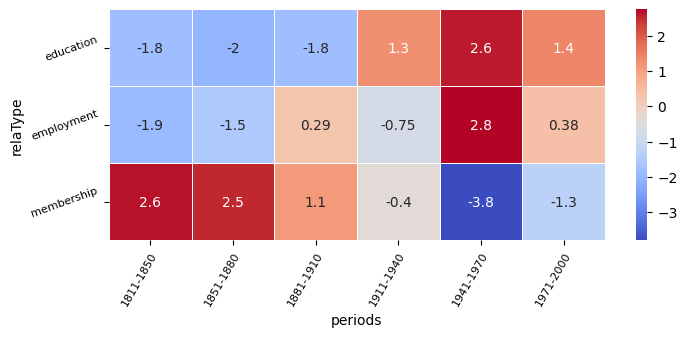

In [55]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 3))

### Explore contingency table of relationships to organisations : periods+types of relationships vs organisations types

In [56]:
df_prep['periods_relaType'] = df_prep.apply(lambda x : x.periods+'_'+x.relaType, axis=1)
df_prep.head(1)

,uriPer,labelPer,birthYear,uriOrg,labelOrg,typesOrg,orgMainType,relaType,periods,periods_relaType
0,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,organization,not classified organisation,employment,1941-1970,1941-1970_employment


In [57]:
### Contingency table
X = 'periods_relaType'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods_relaType,1811-1850_education,1811-1850_employment,1811-1850_membership,1851-1880_education,1851-1880_employment,1851-1880_membership,1881-1910_education,1881-1910_employment,1881-1910_membership,1911-1940_education,1911-1940_employment,1911-1940_membership,1941-1970_education,1941-1970_employment,1941-1970_membership,1971-2000_education,1971-2000_employment,1971-2000_membership,Total
orgMainType,,,,,,,,,,,,,,,,,,,
academy of sciences,0,2,91,0,1,361,1,8,482,2,8,609,0,3,275,0,0,2,1845
astronomical observatory,0,0,0,1,0,0,0,2,0,0,3,0,0,4,0,0,0,0,10
company or gov. agency,0,0,0,0,6,4,0,9,19,0,18,25,0,13,4,0,2,0,100
educational institution,9,2,3,53,9,4,113,16,24,235,19,13,127,22,2,2,0,1,654
institute of technology,1,1,0,9,5,0,16,26,0,25,30,0,25,18,0,1,0,0,157
learned society,0,0,29,0,0,145,0,0,392,2,0,558,0,1,229,0,0,3,1359
not classified organisation,3,3,14,9,4,25,9,7,38,3,26,48,2,11,16,0,0,1,219
private university,0,1,0,6,15,0,44,63,0,122,142,0,58,49,0,2,0,0,502
public university,16,17,0,47,65,0,101,116,0,99,82,0,58,53,0,0,0,0,654


In [58]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [59]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 8634.0 , dof : 204
p-value : 0.0
phi2 = inertie (variance totale) : 1.116657624169574
Cramer:  0.3050488518485706


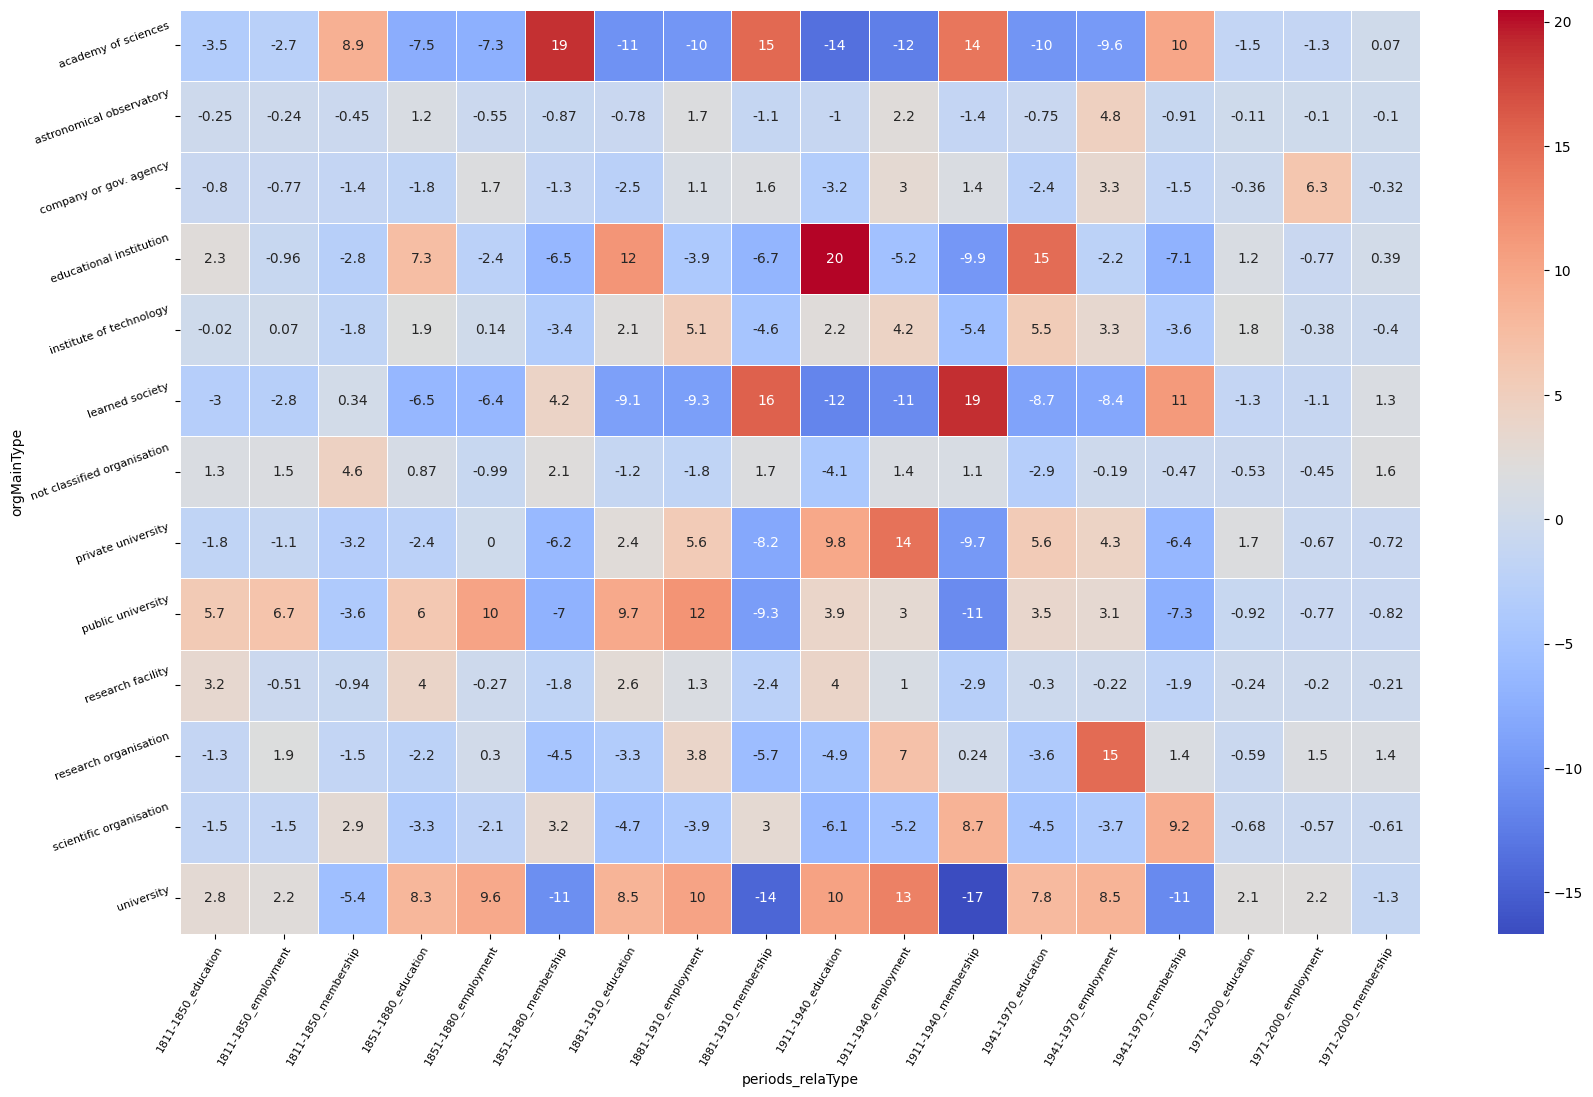

In [60]:
pp = plot_chi2_residuals(ct_wm, figsize=(20, 12))

## Prepare graph


In a heuristic perspective we take the persons as representing relationships among organisations.

Of course these relations are limited in time and with different meaning but in this general inspection of the field, we consider all the relationship. Filters are introduced later on.

We will create a projection of the graph on organisations and keep in a first stage all relationships, with types and periods, one per relationship, where the joining elements are those concerning uniquely the person

In [61]:
### Join on common organisation: Cartesian product -> produces a lot of rows !
merged = pd.merge(df_prep, df_prep, on=['uriPer','labelPer','birthYear', 'periods'])
print(len(merged))


99144


In [62]:
### Eliminate double rows :relationship A-B but relationship B-A
merged = merged[merged['uriOrg_x'] < (merged['uriOrg_y'])]


In [63]:
### Inspect
print(len(merged))
print(list(merged.columns))
merged.iloc[110:114]

45319
['uriPer', 'labelPer', 'birthYear', 'uriOrg_x', 'labelOrg_x', 'typesOrg_x', 'orgMainType_x', 'relaType_x', 'periods', 'periods_relaType_x', 'uriOrg_y', 'labelOrg_y', 'typesOrg_y', 'orgMainType_y', 'relaType_y', 'periods_relaType_y']


,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,periods_relaType_x,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y,periods_relaType_y
256,http://www.wikidata.org/entity/Q102250,Peter Agre,1949,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academic publisher | academy of sciences | pro...,academy of sciences,membership,1941-1970,1941-1970_membership,http://www.wikidata.org/entity/Q858729,Johns Hopkins School of Medicine,medical school | university campus,university,education,1941-1970_education
258,http://www.wikidata.org/entity/Q102250,Peter Agre,1949,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academic publisher | academy of sciences | pro...,academy of sciences,membership,1941-1970,1941-1970_membership,http://www.wikidata.org/entity/Q7366447,Roosevelt High School,high school,educational institution,education,1941-1970_education
259,http://www.wikidata.org/entity/Q102250,Peter Agre,1949,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academic publisher | academy of sciences | pro...,academy of sciences,membership,1941-1970,1941-1970_membership,http://www.wikidata.org/entity/Q83172,Russian Academy of Sciences,academy of sciences | publishing company,academy of sciences,membership,1941-1970_membership
260,http://www.wikidata.org/entity/Q102250,Peter Agre,1949,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academic publisher | academy of sciences | pro...,academy of sciences,membership,1941-1970,1941-1970_membership,http://www.wikidata.org/entity/Q466089,American Philosophical Society,learned society | nonprofit organization,learned society,membership,1941-1970_membership


In [64]:
### Available ORIGINAL relationships
print(df_p.groupby(by='relaType').size())

relaType
education     1996
employment    1876
membership    3860
dtype: int64


In [65]:
### Number of relationships per type prepared for graph
gl_relaType = merged.groupby(['relaType_x', 'relaType_y'], as_index=False).size().sort_values(by='size', ascending=False)

gl_relaType


,relaType_x,relaType_y,size
8,membership,membership,13245
5,employment,membership,6841
2,education,membership,5621
6,membership,education,5089
7,membership,employment,4734
4,employment,employment,2689
3,employment,education,2644
1,education,employment,2238
0,education,education,2218


### Swap values in order to have the same orientation for all relationships

All relationships should have the same 'orientation', which is determined by alphabetical order:

education -> employment -> membership

In [66]:
### Example
df = pd.DataFrame({
    'column1': ['A', 'B', 'C', 'D'],
    'column2': ['X', 'Y', 'Z', 'W']
})

condition = df['column1'] < df['column2']
df.loc[condition, ['column1', 'column2']] = df.loc[condition, ['column2', 'column1']].values

print(df)

  column1 column2
0       X       A
1       Y       B
2       Z       C
3       W       D


In [67]:
### Test whether the relationship types are in the wrong alphabetical order.
condition = merged.relaType_x > merged.relaType_y

In [68]:
### Transpose under condition that the relation orientation is 'wrong',
# i.e. not according the alphabatical order

merged.loc[condition, 
    ['uriOrg_x','labelOrg_x','orgMainType_x','relaType_x', 'uriOrg_y','labelOrg_y','orgMainType_y','relaType_y']] = \
        merged.loc[condition,
    ['uriOrg_y','labelOrg_y','orgMainType_y','relaType_y','uriOrg_x','labelOrg_x','orgMainType_x','relaType_x']].values

In [69]:
### Inspect

merged.iloc[110:117]

,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,periods_relaType_x,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y,periods_relaType_y
256,http://www.wikidata.org/entity/Q102250,Peter Agre,1949,http://www.wikidata.org/entity/Q858729,Johns Hopkins School of Medicine,academic publisher | academy of sciences | pro...,university,education,1941-1970,1941-1970_membership,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,medical school | university campus,academy of sciences,membership,1941-1970_education
258,http://www.wikidata.org/entity/Q102250,Peter Agre,1949,http://www.wikidata.org/entity/Q7366447,Roosevelt High School,academic publisher | academy of sciences | pro...,educational institution,education,1941-1970,1941-1970_membership,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,high school,academy of sciences,membership,1941-1970_education
259,http://www.wikidata.org/entity/Q102250,Peter Agre,1949,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academic publisher | academy of sciences | pro...,academy of sciences,membership,1941-1970,1941-1970_membership,http://www.wikidata.org/entity/Q83172,Russian Academy of Sciences,academy of sciences | publishing company,academy of sciences,membership,1941-1970_membership
260,http://www.wikidata.org/entity/Q102250,Peter Agre,1949,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academic publisher | academy of sciences | pro...,academy of sciences,membership,1941-1970,1941-1970_membership,http://www.wikidata.org/entity/Q466089,American Philosophical Society,learned society | nonprofit organization,learned society,membership,1941-1970_membership
264,http://www.wikidata.org/entity/Q102250,Peter Agre,1949,http://www.wikidata.org/entity/Q760516,Augsburg University,academic publisher | international organizatio...,university,education,1941-1970,1941-1970_membership,http://www.wikidata.org/entity/Q40358,American Association for the Advancement of Sc...,private not-for-profit educational institution...,scientific organisation,membership,1941-1970_education
265,http://www.wikidata.org/entity/Q102250,Peter Agre,1949,http://www.wikidata.org/entity/Q40358,American Association for the Advancement of Sc...,academic publisher | international organizatio...,scientific organisation,membership,1941-1970,1941-1970_membership,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,academic publisher | learned society | nonprof...,learned society,membership,1941-1970_membership
266,http://www.wikidata.org/entity/Q102250,Peter Agre,1949,http://www.wikidata.org/entity/Q858729,Johns Hopkins School of Medicine,academic publisher | international organizatio...,university,employment,1941-1970,1941-1970_membership,http://www.wikidata.org/entity/Q40358,American Association for the Advancement of Sc...,medical school | university campus,scientific organisation,membership,1941-1970_employment


In [70]:
### Number of relationships per type prepared for graph
gl_relaType = merged.groupby(['relaType_x', 'relaType_y'], as_index=False).size().sort_values(by='size', ascending=False)

gl_relaType


,relaType_x,relaType_y,size
5,membership,membership,13245
4,employment,membership,11575
2,education,membership,10710
1,education,employment,4882
3,employment,employment,2689
0,education,education,2218


In [71]:
### Concat relationships
merged['relaType_concat'] = merged.apply(lambda x: x.relaType_x + '_' +x.relaType_y, axis=1)

In [72]:
print(list(merged.columns))
merged.iloc[110:112]


['uriPer', 'labelPer', 'birthYear', 'uriOrg_x', 'labelOrg_x', 'typesOrg_x', 'orgMainType_x', 'relaType_x', 'periods', 'periods_relaType_x', 'uriOrg_y', 'labelOrg_y', 'typesOrg_y', 'orgMainType_y', 'relaType_y', 'periods_relaType_y', 'relaType_concat']


,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,periods_relaType_x,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y,periods_relaType_y,relaType_concat
256,http://www.wikidata.org/entity/Q102250,Peter Agre,1949,http://www.wikidata.org/entity/Q858729,Johns Hopkins School of Medicine,academic publisher | academy of sciences | pro...,university,education,1941-1970,1941-1970_membership,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,medical school | university campus,academy of sciences,membership,1941-1970_education,education_membership
258,http://www.wikidata.org/entity/Q102250,Peter Agre,1949,http://www.wikidata.org/entity/Q7366447,Roosevelt High School,academic publisher | academy of sciences | pro...,educational institution,education,1941-1970,1941-1970_membership,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,high school,academy of sciences,membership,1941-1970_education,education_membership


In [73]:
df_graph=merged.groupby(['periods', 'relaType_concat', 'uriOrg_x', 'labelOrg_x', 'orgMainType_x',  
                         'uriOrg_y', 'labelOrg_y', 'orgMainType_y'],
               as_index=False)\
    .agg({'labelPer': '|'.join, 'uriPer': '|'.join})

df_graph['number'] = df_graph.labelPer.apply(lambda x : len(x.split('|')))


In [74]:
print(len(df_graph))
df_graph.sort_values('number',ascending=False).head()


30618


,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
24688,1911-1940,membership_membership,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,Sidney Altman|Christian B. Anfinsen|Paul Berg|...,http://www.wikidata.org/entity/Q102266|http://...,184
23888,1911-1940,membership_membership,http://www.wikidata.org/entity/Q123885,Royal Society,learned society,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,Paul Berg|Derek Barton|Andrew Huxley|Vitaly Gi...,http://www.wikidata.org/entity/Q102379|http://...,101
13848,1881-1910,membership_membership,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,Peter Debye|Wendell Meredith Stanley|John Howa...,http://www.wikidata.org/entity/Q103835|http://...,97
23914,1911-1940,membership_membership,http://www.wikidata.org/entity/Q123885,Royal Society,learned society,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,Paul Berg|Derek Barton|Andrew Huxley|Vitaly Gi...,http://www.wikidata.org/entity/Q102379|http://...,93
30277,1941-1970,membership_membership,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,Duncan Haldane|Peter Agre|Bruce Beutler|Jack S...,http://www.wikidata.org/entity/Q1002250|http:/...,83


### Explore contingency table of relationship pairs to periods

In [75]:


### Contingency table
X = 'periods'
Y = 'relaType_concat'  

ddf = df_graph[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1811-1850,1851-1880,1881-1910,1911-1940,1941-1970,1971-2000,Total
relaType_concat,,,,,,,
education_education,41,232,508,864,432,12,2089
education_employment,108,542,1151,1813,974,20,4608
education_membership,347,1291,2089,3121,1388,29,8265
employment_employment,53,323,757,903,473,7,2516
employment_membership,362,1423,2353,2768,1298,22,8226
membership_membership,435,1032,1202,1613,619,13,4914
Total,1346,4843,8060,11082,5184,103,30618


In [76]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [77]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 760.16 , dof : 25
p-value : 3.019746871490704e-144
phi2 = inertie (variance totale) : 0.02482707513623658
Cramer:  0.07046570106972126


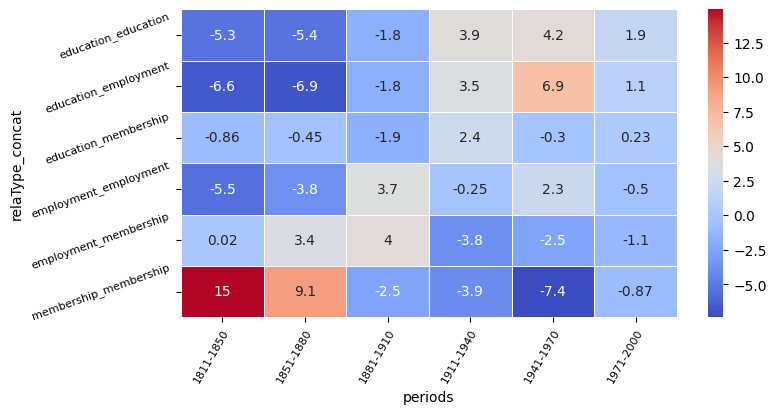

In [78]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 4))

## Graph analysis


We will explore some aspects of the relationships:

* which organisations are connected through education, but this only at the level of universities, not earlier education stages
* in the same perspective (same kind of relations), we will explore memberships and employments, keeping them separated
* we will then ask what appears regarding the relationship between employment and membership
* we finally inspect if some kind of educational institutions (at unversity level) lead to specific employments or memberships.






### Organisations connected through higher education

In [79]:
pprint.pprint(sorted(df_mainTypes.mainType.to_list()))

['academy of sciences',
 'astronomical observatory',
 'company or gov. agency',
 'educational institution',
 'institute of technology',
 'learned society',
 'not classified organisation',
 'private university',
 'public university',
 'research facility',
 'research organisation',
 'scientific organisation',
 'university']


In [80]:
types_list=['university', 'public university', 'private university']

In [81]:
df_edu_graph = df_graph[(df_graph.relaType_concat == 'education_education') \
                     & (df_graph.orgMainType_x.isin(types_list)) \
                     & (df_graph.orgMainType_y.isin(types_list))  ]

print(len(df_edu_graph))
df_edu_graph.iloc[:2]

796


,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
1,1811-1850,education_education,http://www.wikidata.org/entity/Q106947038,Q106947038,university,http://www.wikidata.org/entity/Q152838,University of Göttingen,public university,Élie Metchnikoff,http://www.wikidata.org/entity/Q172254,1
3,1811-1850,education_education,http://www.wikidata.org/entity/Q1137665,Ghent University,public university,http://www.wikidata.org/entity/Q151510,Heidelberg University,public university,Adolf von Baeyer,http://www.wikidata.org/entity/Q57078,1


In [82]:
df_edu_graph.sort_values(by='number',ascending=False).iloc[:2]

,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
14837,1911-1940,education_education,http://www.wikidata.org/entity/Q332342,Trinity College,university,http://www.wikidata.org/entity/Q35794,University of Cambridge,university,Brian David Josephson|Aaron Klug|Walter Gilber...,http://www.wikidata.org/entity/Q181363|http://...,6
25401,1941-1970,education_education,http://www.wikidata.org/entity/Q13371,Harvard University,private university,http://www.wikidata.org/entity/Q168756,"University of California, Berkeley",university,Adam Riess|Saul Perlmutter|David Gross|David J...,http://www.wikidata.org/entity/Q106454|http://...,5


In [83]:
### Number of relationships by period
print(df_edu_graph.groupby('periods').size())

periods
1811-1850     20
1851-1880     97
1881-1910    206
1911-1940    324
1941-1970    143
1971-2000      6
dtype: int64


### Inspect a specific period

In [84]:
p = '1881-1910' #'1851-1880' #'1911-1940'

In [85]:
df_edu_graph_p = df_edu_graph[(df_edu_graph.periods==p)]
df_edu_graph_p.sort_values(by='number',ascending=False).head(2)

,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
6571,1881-1910,education_education,http://www.wikidata.org/entity/Q332342,Trinity College,university,http://www.wikidata.org/entity/Q35794,University of Cambridge,university,William Lawrence Bragg|Subrahmanyan Chandrasek...,http://www.wikidata.org/entity/Q131729|http://...,5
6331,1881-1910,education_education,http://www.wikidata.org/entity/Q152087,Humboldt-Universität zu Berlin,university,http://www.wikidata.org/entity/Q55044,Ludwig-Maximilians-Universität München,public university,Gustav Ludwig Hertz|Hans Krebs|Fritz Albert Li...,http://www.wikidata.org/entity/Q57070|http://w...,3


In [86]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriOrg_x'], e['uriOrg_y'],
     {'uriPers':e['uriPer'], 'labelPers':e['labelPer'],
      ## the weight ist the number of persons in this relationship
      'weight':e['number']}
     )) 
     for e in df_edu_graph_p.to_dict(orient='records')]
print(len(l))

206


In [87]:
edu_graph_p=nx.Graph()

## Add relationships to graph
# Multiple rows between two edges are taken only once
edu_graph_p.add_edges_from(l)

naf.basic_graph_properties(edu_graph_p)

### Create a list of graphs, one per component
edu_graph_p_S = [edu_graph_p.subgraph(c).copy() for c in nx.connected_components(edu_graph_p)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(edu_graph_p_S)], key = lambda row: row[1], reverse=True)
print(ln[:5])

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 132,
 'number_of_edges': 206,
 '------': '------',
 'is connected': False,
 'components': 13,
 'density': 0.023826046726810084}
[[0, 104], [4, 3], [6, 3], [8, 3], [9, 3]]


In [88]:
### test if second component is significantly smaller 
# than first
if ln[1][1]*20 < ln[0][1]:
    print('Just one big component')
else :
    print('Beware: more than one big component !')    

Just one big component


In [89]:
### Alternative way with just one graph
pG = edu_graph_p_S[0]
naf.basic_graph_properties(pG)

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 104,
 'number_of_edges': 187,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 0.03491411501120239}


In [90]:
df_orgPeriod.sort_values(by='period_members_number', ascending=False).head(2)

,uriOrg,labelOrg,orgMainType,periods,period_members_number
1007,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,1911-1940,219
1463,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,1911-1940,214


In [91]:
df_opl = df_orgPeriod[df_orgPeriod.periods==p][['uriOrg', 'labelOrg', 'orgMainType', 'period_members_number']]
df_opl.columns=['uri', 'label', 'mainType', 'membersNumber']
df_opl.head()


,uri,label,mainType,membersNumber
0,http://www.wikidata.org/entity/Q1003730,Bulgarian Academy of Sciences,academy of sciences,1
3,http://www.wikidata.org/entity/Q1016927,Burroughs Wellcome & Company,company or gov. agency,1
4,http://www.wikidata.org/entity/Q1016986,Burschenschaft Alemannia Marburg,not classified organisation,1
9,http://www.wikidata.org/entity/Q102398208,German University in Prague Medical School,university,2
26,http://www.wikidata.org/entity/Q1047060,Case Western Reserve University,private university,1


In [92]:
### Prepare data to add to nodes
ln = dict([(e['uri'],
     {'label':e['label'], 'mainType':e['mainType'],
                        'membersNumber':e['membersNumber']}
     ) for e in df_opl.to_dict(orient='records')])
## Add attributes
nx.set_node_attributes(pG, ln)
pprint.pprint(list(pG.nodes.data())[:2])


[('http://www.wikidata.org/entity/Q102398208',
  {'label': 'German University in Prague Medical School',
   'mainType': 'university',
   'membersNumber': 2}),
 ('http://www.wikidata.org/entity/Q154804',
  {'label': 'Leipzig University',
   'mainType': 'public university',
   'membersNumber': 7})]


In [93]:
mn_s = pd.Series([n[1]['mainType'] for n in pG.nodes.data()])
print(mn_s.groupby(by=mn_s).size().sort_values(ascending=False))

university            61
public university     33
private university    10
dtype: int64


####  Create dataframe and inspect node properties

In [94]:
### Eigenvector
le = list(nx.eigenvector_centrality(pG, 
                        max_iter=200, weight='weight').items())
nx.set_node_attributes(pG, dict(le), 'eigenvector')
pprint.pprint(list(pG.nodes.data())[:1])

[('http://www.wikidata.org/entity/Q102398208',
  {'eigenvector': 0.002069402587677239,
   'label': 'German University in Prague Medical School',
   'mainType': 'university',
   'membersNumber': 2})]


In [95]:
### Betweenness
lb = list(nx.betweenness_centrality(pG, weight='weight').items())
nx.set_node_attributes(pG, dict(lb), 'betweenness')
pprint.pprint(list(pG.nodes.data())[:1])


[('http://www.wikidata.org/entity/Q102398208',
  {'betweenness': 0.0,
   'eigenvector': 0.002069402587677239,
   'label': 'German University in Prague Medical School',
   'mainType': 'university',
   'membersNumber': 2})]


In [96]:
### Export node attributes to dataframe
nodes_data ={node: pG.nodes[node] for node in pG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True, names='id')
nodes_df.head(2)


,id,label,mainType,membersNumber,eigenvector,betweenness
0,http://www.wikidata.org/entity/Q102398208,German University in Prague Medical School,university,2,0.002069,0.0
1,http://www.wikidata.org/entity/Q154804,Leipzig University,public university,7,0.012834,0.093343


In [97]:
df_mainTypes

,mainType,number
0,academy of sciences,1845
12,university,1554
5,learned society,1438
3,educational institution,654
8,public university,654
7,private university,502
11,scientific organisation,361
6,not classified organisation,219
10,research organisation,194
4,institute of technology,157


In [98]:
### exclude less relevant or dirty classifications
lt=[t for t in df_mainTypes.mainType.to_list()
                if ('educat' not in t)  & ('classif' not in t)]
pprint.pprint(lt)

['academy of sciences',
 'university',
 'learned society',
 'public university',
 'private university',
 'scientific organisation',
 'research organisation',
 'institute of technology',
 'company or gov. agency',
 'research facility',
 'astronomical observatory']


In [99]:
### source
# https://phrogz.net/css/distinct-colors.html
col_l = [c.strip() for c in '#ff0066, #0000ff, #00aaff,#beb6f2, #b6e6f2, #e6f2b6, #f2b6b6,#2d50b3, #ccff00, #8c005e, #8c8300'.split(',')]
print(col_l)

['#ff0066', '#0000ff', '#00aaff', '#beb6f2', '#b6e6f2', '#e6f2b6', '#f2b6b6', '#2d50b3', '#ccff00', '#8c005e', '#8c8300']


In [100]:
col_list= [e for e in zip(lt, col_l)]
print(col_list)

[('academy of sciences', '#ff0066'), ('university', '#0000ff'), ('learned society', '#00aaff'), ('public university', '#beb6f2'), ('private university', '#b6e6f2'), ('scientific organisation', '#e6f2b6'), ('research organisation', '#f2b6b6'), ('institute of technology', '#2d50b3'), ('company or gov. agency', '#ccff00'), ('research facility', '#8c005e'), ('astronomical observatory', '#8c8300')]


In [101]:
color_map=dict([(c[0], (c[1])) for c in col_list])
pprint.pprint(color_map)

{'academy of sciences': '#ff0066',
 'astronomical observatory': '#8c8300',
 'company or gov. agency': '#ccff00',
 'institute of technology': '#2d50b3',
 'learned society': '#00aaff',
 'private university': '#b6e6f2',
 'public university': '#beb6f2',
 'research facility': '#8c005e',
 'research organisation': '#f2b6b6',
 'scientific organisation': '#e6f2b6',
 'university': '#0000ff'}


In [102]:
### Manually modified list
color_map = {'academy of sciences': '#00aaff',
 'astronomical observatory': '#8c005e',
 'company or gov. agency': '#ccff00',
 'institute of technology': '#f2b6b6',
 'learned society': '#ff0066',
 'private university': '#ffcc00',
 'public university': '#8c8300',
 'research facility': '#d90000',
 'research organisation': '#beb6f2',
 'scientific organisation': '#2d50b3',
 'university': '#b6e6f2'}

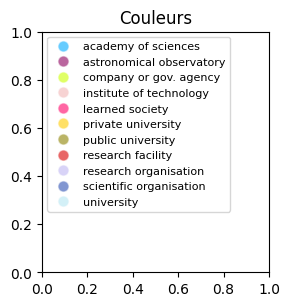

In [103]:

fig = plt.figure(figsize=(3,3))


### Create lists of colors and labels
colors = [color_map.keys()]
 

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                            label=label, markerfacecolor=color, 
                            markersize=8, alpha=0.6
                            ) for label, color in color_map.items() ],
                            loc='upper left', fontsize=8)
plt.tight_layout() # rect=[0,0,0.8,1]

plt.title('Couleurs')

plt.show()

In [104]:
### Create a function that plots the comparison between values and properties

def compare_with_scatter_plot(dataframe, value_1, value_2, point_column,point_ratio=1, 
                              c_category='', color_map='', figsize=(12,12), 
                              legend_loc='upper right',title='', 
                              n_label ='', label_cut_value=''):

    ### https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
    # Different colors per class : https://vitalflux.com/python-scatter-plot-different-classes/
    # Legend : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
    # Labels : https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point



    df=dataframe
    # df_extr=nodes_df[nodes_df.betweenness > 0].sort_values(by='betweenness', ascending=False)

    alpha=0.7

    ### Manage point colors:
    # https://kanoki.org/2020/08/30/matplotlib-scatter-plot-color-by-category-in-python/

    plt.figure(figsize=figsize)


    ### Create lists of colors and labels
    colors = [color_map[category] for category in df[c_category]]
 



    ax = plt.scatter(df[value_1],
                df[value_2],
            marker='o',
            s = [v*point_ratio for i,v in df[point_column].items()],
            color=colors,        
            alpha=alpha)
    plt.xlabel(value_1.capitalize())
    plt.ylabel(value_2.capitalize())






    ### Labels
    test_v1 = df[value_1].quantile([0.97]).item()
    test_v2 = df[value_2].quantile([0.95]).item()
    print(test_v1,test_v2)


    if len(n_label)>0:
        for i,row in list(df.loc[(df[value_1]>test_v1)|(df[value_2]>test_v2)]\
                          [[n_label,value_1,value_2]].iterrows()):
            plt.annotate(row[n_label][:30],(row[value_1], row[value_2]), fontsize=6)

    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                            label=label, markerfacecolor=color, 
                            markersize=8, alpha=alpha
                            ) for label, color in color_map.items() 
                                    if label in types_list ],
                            loc=legend_loc, fontsize=8)
    plt.tight_layout() # rect=[0,0,0.8,1]

    plt.title(title)

    # plt.savefig('plots/revenus_eigenvector_20210526.jpg')
    plt.show()

0.29526409402525855 0.1415936924931785


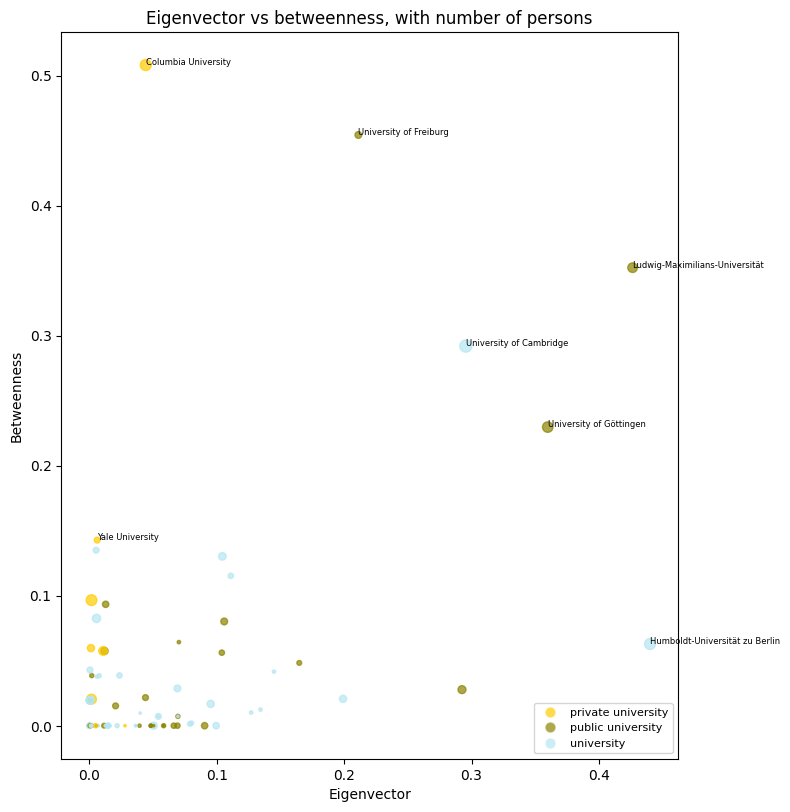

Spearman's rank correlation: 0.354406579181464


In [105]:
compare_with_scatter_plot(nodes_df, 'eigenvector', 'betweenness', 'membersNumber', 
                          point_ratio=3, c_category='mainType',
                          color_map=color_map, figsize=(8,8), 
                          legend_loc='lower right', 
                          title='Eigenvector vs betweenness, with number of persons', 
                          n_label='label', label_cut_value='membersNumber' )

corr_spear = nodes_df[['eigenvector', 'betweenness']].corr(method="spearman")
print("Spearman's rank correlation: {}".format(corr_spear.iloc[0,1]))

In [106]:
list(nodes_df.columns)

['id', 'label', 'mainType', 'membersNumber', 'eigenvector', 'betweenness']

In [107]:
print('Betweenness')
pprint.pprint((nodes_df.sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(7)))
print('\n-----\nEigenvector')
pprint.pprint((nodes_df.sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(7)))

Betweenness
                                     label            mainType membersNumber
59                     Columbia University  private university            21
48                  University of Freiburg   public university             8
45  Ludwig-Maximilians-Universität München   public university            16
12                 University of Cambridge          university            26
5                  University of Göttingen   public university            19
22                         Yale University  private university             6
34                     University of Paris          university             6

-----
Eigenvector
                                     label           mainType membersNumber
9           Humboldt-Universität zu Berlin         university            21
45  Ludwig-Maximilians-Universität München  public university            16
5                  University of Göttingen  public university            19
12                 University of Cambridge       

#### Plot graph

In [108]:
pict_addr = 'images/organisations/edu_edu_' + p +'.svg'
print(pict_addr)

images/organisations/edu_edu_1881-1910.svg


In [109]:
### Plot the graph

g = pG
# n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
n_size = np.log(nx.number_of_nodes(g))*10

graph_layout = 'spring_layout'
n_k = np.log(nx.number_of_nodes(g))/20 #2.5

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
#node_size = [d[1]*100 for d in nx.degree(g)]
node_colors= [color_map[n[1]['mainType']] for n in g.nodes.data()]

edge_size = [e[2]['weight'] for e in g.edges.data()]
edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color=node_colors, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
#nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

alpha_n=0.5

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                        label=label, markerfacecolor=color, 
                        markersize=12, alpha=alpha_n
                        )
                        for label, color in color_map.items()
                        if label in types_list ],
                        loc='lower right', fontsize=12)


### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
pict_addr = pict_addr
plt.savefig(pict_addr)
#plt.show()
plt.close()


### Communitites

In [110]:
l_communities = [(c, len(c)) for c in list(nx.community.louvain_communities(pG, resolution=0.7, weight='weight'))]
print( len(l_communities))
sl_communities = sorted(l_communities, key=lambda x: x[1], reverse=True)
print([c[1] for c in sl_communities])
print(sl_communities[-1:])


7
[27, 23, 19, 12, 9, 8, 6]
[({'http://www.wikidata.org/entity/Q1729754', 'http://www.wikidata.org/entity/Q154804', 'http://www.wikidata.org/entity/Q102398208', 'http://www.wikidata.org/entity/Q3563550', 'http://www.wikidata.org/entity/Q193196', 'http://www.wikidata.org/entity/Q31519'}, 6)]


In [111]:
for i in range(0,5):
   print('\n\nCommunity '+ str(i), '\nBetweenness')
   pprint.pprint((nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(4)))
   print('\n-----\nEigenvector')
   pprint.pprint((nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(4)))




Community 0 
Betweenness
                                     label           mainType membersNumber
48                  University of Freiburg  public university             8
45  Ludwig-Maximilians-Universität München  public university            16
5                  University of Göttingen  public university            19
44                   University of Wrocław         university             5

-----
Eigenvector
                                     label           mainType membersNumber
9           Humboldt-Universität zu Berlin         university            21
45  Ludwig-Maximilians-Universität München  public university            16
5                  University of Göttingen  public university            19
41                   Heidelberg University  public university            11


Community 1 
Betweenness
                   label            mainType membersNumber
22       Yale University  private university             6
34   University of Paris          university     

#### Plot communitites graph

In [112]:
pict_addr_comm = 'images/organisations/edu_edu_communities_' + p +'.svg'
print(pict_addr_comm)

images/organisations/edu_edu_communities_1881-1910.svg


In [113]:
### Plot the graph

g = pG
# n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
n_size = np.log(nx.number_of_nodes(g))*10

graph_layout = 'spring_layout'
n_k = np.log(nx.number_of_nodes(g))/20 #2.5

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
#node_size = [d[1]*100 for d in nx.degree(g)]

node_colors = []
for n in g.nodes.data():
    if n[0] in list(sl_communities[0][0]):
        node_colors.append('red')
    elif n[0] in list(sl_communities[1][0]):
        node_colors.append('blue')
    elif n[0] in list(sl_communities[2][0]):
        node_colors.append('green')
    elif n[0] in list(sl_communities[3][0]):
        node_colors.append('orange')
    elif n[0] in list(sl_communities[4][0]):
        node_colors.append('maroon')
    else:
        node_colors.append('lightGrey')        


edge_size = [e[2]['weight'] for e in g.edges.data()]
edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color=node_colors, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
#nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

alpha_n=0.5



### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
pict_addr = pict_addr_comm
plt.savefig(pict_addr)
#plt.show()
plt.close()


## Create general function

In [114]:
def generate_report_and_plots(df, concatRelaType, type_list, doc_addr, df_orgPeriod):

    with open(doc_addr, "w") as myfile:
        myfile.write('# Report for relations: ' + concatRelaType + '\n')


    df_g = df[(df.relaType_concat == concatRelaType) \
                     & (df.orgMainType_x.isin(type_list)) \
                     & (df.orgMainType_y.isin(type_list))  ]

    txt = str(df_g.groupby('periods').size())

    with open(doc_addr, "a") as myfile:
        myfile.write('\n'+txt + '\n')

    for p in df_g['periods'].unique():
        print(str(p))   

        with open(doc_addr, "a") as myfile:
            myfile.write('\n\n\n## Values for ' + p + '\n')

        df_g_p = df_g[df_g.periods==p]
        
        with open(doc_addr, "a") as myfile:
            myfile.write('\nNumber of relationships for this period ' + str(len(df_g_p)) + '\n')
        
        l = [tuple(
            (e['uriOrg_x'], e['uriOrg_y'],
            {'uriPers':e['uriPer'], 'labelPers':e['labelPer'],
            ## the weight ist the number of persons in this relationship
            'weight':e['number']}
            )) 
            for e in df_g_p.to_dict(orient='records')]
        
        graph_p=nx.Graph()
        graph_p.add_edges_from(l)

        txt = 'Number of nodes: ' + str(graph_p.number_of_nodes())+\
                '\nNumber of edges: ' + str(graph_p.number_of_edges())
        with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

        ### Components
        graph_p_S = [graph_p.subgraph(c).copy() 
                     for c in nx.connected_components(graph_p)]

        ln = sorted([[i,len(s.nodes)] for i,s in enumerate(graph_p_S)], key = lambda row: row[1], reverse=True)
        try:
            if ln[1][1]*20 < ln[0][1]:
                with open(doc_addr, "a") as myfile:
                    myfile.write('\nJust one big component with ' + str(graph_p_S[0].number_of_nodes()) + ' nodes\n')            
            else :
                with open(doc_addr, "a") as myfile:
                    myfile.write('\nBeware: more than one big component !'  + '\n')
        except Exception as e:
             print(e)            
            
        ### Alternative way with just one graph
        pG = graph_p_S[0]

        txt = 'Number of nodes for first component: ' + str(pG.number_of_nodes())+\
                '\nNumber of edges for first component: ' + str(pG.number_of_edges())
        with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

        ### No treatment for smaller graphs
        if int(pG.number_of_nodes()) > 30:

            ### Prepare data to add to nodes

            df_opl = df_orgPeriod[df_orgPeriod.periods==p][['uriOrg', 'labelOrg', 'orgMainType', 'period_members_number']]
            df_opl.columns=['uri', 'label', 'mainType', 'membersNumber']

            ln = dict([(e['uri'],
                {'label':e['label'], 'mainType':e['mainType'],
                                    'membersNumber':e['membersNumber']}
                ) for e in df_opl.to_dict(orient='records')])
            ## Add attributes
            nx.set_node_attributes(pG, ln)

            mn_s = pd.Series([n[1]['mainType'] for n in pG.nodes.data()])
            txt= str(list(mn_s.groupby(by=mn_s).size().sort_values(ascending=False).items()))
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

            ### Eigenvector
            try:
                le = list(nx.eigenvector_centrality(pG, 
                                        max_iter=1000, weight='weight').items())
            except Exception as e:
                print(e)    
            nx.set_node_attributes(pG, dict(le), 'eigenvector')   

            ### Betweenness
            lb = list(nx.betweenness_centrality(pG, weight='weight').items())
            nx.set_node_attributes(pG, dict(lb), 'betweenness')


            ### Export node attributes to dataframe
            nodes_data ={node: pG.nodes[node] for node in pG.nodes}
            nodes_df = pd.DataFrame(nodes_data).T
            nodes_df.reset_index(inplace=True, names='id')

            corr_spear = nodes_df[['eigenvector', 'betweenness']].corr(method="spearman")
            txt = "Spearman's rank correlation of eidenvector and betweenness: {}".format(corr_spear.iloc[0,1])
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

            txt = 'Eigenvector\n' + \
                str(nodes_df.sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(7) )+\
                '\n-----\nBetweenness'+\
                str(nodes_df.sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(7))
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')


            pict_addr = 'images/organisations/' + concatRelaType + '_' + p +'.svg'        


            ### Plot the graph
            g = pG
            # n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
            n_size = np.log(nx.number_of_nodes(g))*10

            graph_layout = 'spring_layout'
            n_k = np.log(nx.number_of_nodes(g))/20 #2.5

            ### Define the layout, i.e. the choice 
            # of the algorithm for the representation of the graph.

            if graph_layout == 'fruchterman_reingold':
                pos = nx.fruchterman_reingold_layout(g)
            elif graph_layout == 'kamada_kawai':
                pos = nx.kamada_kawai_layout(g)
            elif graph_layout == 'spring_layout':
                pos = nx.spring_layout(g, k = n_k)  
            else:
                pos = nx.kamada_kawai_layout(g)

            # https://networkx.org/documentation/stable/reference/drawing.html
            plt.figure(figsize = (n_size,n_size))

            node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
            #node_size = [d[1]*100 for d in nx.degree(g)]
            #node_colors= [color_map[n[1]['mainType']] for n in g.nodes.data()]

            edge_size = [e[2]['weight'] for e in g.edges.data()]
            edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

            node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


            nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color='blue', alpha=0.6)
            nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
            nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
            #nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

            alpha_n=0.5

            plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                                    label=label, markerfacecolor=color, 
                                    markersize=8, alpha=alpha_n
                                    )
                                    for label, color in color_map.items()],
                                    loc='lower right', fontsize=8)


            ### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
            plt.tight_layout(pad=60)
            pict_addr = pict_addr
            plt.savefig(pict_addr)
            #plt.show()
            plt.close()


            ### Identify communitites
            l_communities = [(c, len(c)) for c in list(nx.community.louvain_communities(pG, resolution=0.7, weight='weight'))]
            sl_communities = sorted(l_communities, key=lambda x: x[1], reverse=True)
            txt= 'Number of communitites: ' + str(len(l_communities)) +\
                    '\nNumber of nodes per community: ' + str([c[1] for c in sl_communities])
            with open(doc_addr, "a") as myfile:
                myfile.write('\n'+ txt  + '\n')

            communities_print = 'Communities: \n'
            try:
                for i in range(0,5):
                    communities_print += '\n\nCommunity '+ str(i) + '\nBetweenness'
                    communities_print += str(nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ]\
                                                .sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(5).to_markdown())
                    communities_print += '\n-----\nEigenvector'
                    communities_print += str(nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(5).to_markdown())
                with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ communities_print  + '\n')
            except Exception as e:
                 print(e)        

        else:
            print('Too small graph to be analyzed!')        


In [115]:
print(df_mainTypes.mainType.to_list())

['academy of sciences', 'university', 'learned society', 'educational institution', 'public university', 'private university', 'scientific organisation', 'not classified organisation', 'research organisation', 'institute of technology', 'company or gov. agency', 'research facility', 'astronomical observatory']


In [118]:
relationship_type = 'education_education'
generate_report_and_plots(df_graph, relationship_type,
                           ['university','public university','private university'],
                           'analysis_doc/'+relationship_type+'.md',
                           df_orgPeriod)

1811-1850
Too small graph to be analyzed!
1851-1880
list index out of range
1881-1910
1911-1940
1941-1970
Too small graph to be analyzed!
1971-2000
list index out of range
Too small graph to be analyzed!


In [119]:
relationship_type = 'membership_membership'
generate_report_and_plots(df_graph, relationship_type,
                           ['university',
                            'public university',
                            'academy of sciences',
                            'learned society',
                            'private university',
                            'research organisation',
                            'institute of technology',
                            'scientific organisation',
                            'astronomical observatory',
                            'research facility',
                            'company',
                            'governmenmt agency',
                            'publisher_edition'],
                           'analysis_doc/'+ relationship_type+'.md',
                           df_orgPeriod)

1811-1850
list index out of range
1851-1880
list index out of range
1881-1910
list index out of range
list index out of range
1911-1940
list index out of range
1941-1970
list index out of range
1971-2000
list index out of range
Too small graph to be analyzed!


In [120]:
relationship_type = 'employment_employment'
generate_report_and_plots(df_graph, relationship_type,
                           ['university',
                            'public university',
                            'academy of sciences',
                            'learned society',
                            'private university',
                            'research organisation',
                            'institute of technology',
                            'scientific organisation',
                            'astronomical observatory',
                            'research facility',
                            'company',
                            'governmenmt agency',
                            'publisher_edition'],
                           'analysis_doc/'+ relationship_type+'.md',
                           df_orgPeriod)

1811-1850
Too small graph to be analyzed!
1851-1880
Too small graph to be analyzed!
1881-1910
Too small graph to be analyzed!
1911-1940
1941-1970
Too small graph to be analyzed!
1971-2000
list index out of range
Too small graph to be analyzed!
